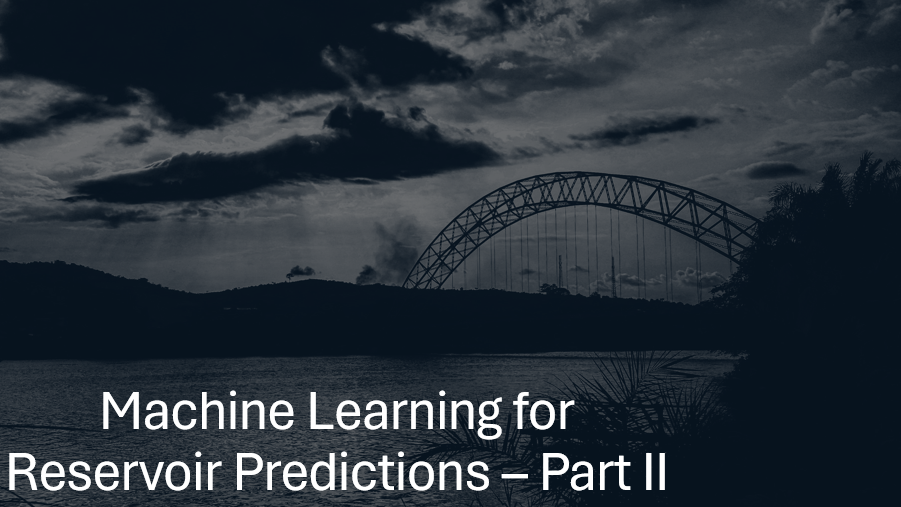

This notebook covers a range of extension exercises building on the work in ML\_reservoir\_prediction.ipynb, including:

- building a Random Forest model for a different example reservoir;

 - try a different type of ensemble-tree model for an example reservoir;

 - using the model for forecasting.

In [ ]:
# install a hydrometrics package
!pip install hydroeval

In [ ]:
# import required packages

# standard scientific packages
import numpy as np
import pandas as pd
import datetime as dt

# plotting packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
import calendar

# various metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import hydroeval as he

# ML packages (see https://scikit-learn.org/stable/api/sklearn.ensemble.html for more info)
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor


# Different reservoir

Make a copy of the previous notebook (ML\_reservoir\_prediction.ipynb) and rerun with different reservoir data.

We have three example reservoirs in total: J2R006; C1R001; and 2026 (see READ_ME.txt for information on these reservoirs).
To change the data being read in, adapt the line:

data = pd.read_csv('data/C1R001_GH.csv')


🤔**Questions**

 - Does the model perform better or worse for the other reservoir?

 - How do the reservoir characterstics impact model performance?

 - What other applications might be suited to ML modelling?


# Different model

Make a copy of the previous notebook (ML\_reservoir\_prediction.ipynb) and rerun with different ensemble-tree model.

Examples that have already been imported as packages are: AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor (you are welcome to import more models if you wish). There are lots of resources online to help you to understand the differences between these models, should you wish to explore further.

To change the model being used replace all instances of "RandomForestRegressor" with your new model. Consider testing multiple models.

Remember that some of the models have different **hyperparameters**, so you will also need to adapt the hyperparameter tuning section if you choose to do that bit (e.g. AdaBoostRegressor and GradientBoostingRegressor do not have bootstrap).


🤔**Questions**

 - Does the model perform better or worse compared to the Random Forest model?

 - Which model is more at risk of overfitting? How easy is it to reduce this risk with hyperparameter tuning?

 - What other applications might be suited to ML modelling?

# Forecasting

So far we have run the model in **simulation mode**, using observed precipitation and temperature to produce a prediction. In **forecast mode** we need climate forecasts to produce our storage forecast.

As this is a training exercise, we have synthesized a year of forecast data for the Vaal reservoir which we will use to explore forecasting. To keep things simple, we have made two datasets for use in training and forecasting. This includes all of the feature engineering that we used in the first notebook.

In [17]:
# fetch the data from github
%%capture
!wget https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/refs/heads/main/Day2_Water_Resources_Modelling/data.zip

In [ ]:
# now unzip data.zip
%%capture
!unzip data.zip # unzip folder

In [ ]:
# open the training and forecast data for the Vaal reservoir
training_data = pd.read_csv('data/C1R001_GH_FCtraining.csv')
forecast_data = pd.read_csv('data/C1R001_GH_FC.csv')

training_data['date'] = pd.to_datetime(training_data['date'])
forecast_data['date'] = pd.to_datetime(forecast_data['date'])

training_data = training_data.set_index('date').sort_index()
forecast_data = forecast_data.set_index('date').sort_index()

In [ ]:
# we have kept all the features in this example, if you wish to select a subset of explanatory features you can do this here
# by uncommenting feature_subset = ['storage','precipitation','temperature'] and adding the desired features to the list
# (storage, precipitation and temperature are required for the following code so have been added already)

feature_subset = training_data.columns.to_list()
#feature_subset = ['storage','precipitation','temperature']
training_data = training_data[feature_subset]
training_X, training_y = training_data.drop(columns='storage'), training_data['storage'] # split into explanatory and target variables

In [ ]:
# here we use the Random Forest model again, with default hyperparameters
# if you want to change this, do it here
model = RandomForestRegressor(random_state=345)
model.fit(training_X,training_y)

In [ ]:
# now we will make our first forecast!

temp = forecast_data.iloc[0] # select the forecast for January
# replace the observed precipitation and temperature with forecast values (in a real forecast this step will be unnecessary since you won't have observed values)
temp['precipitation'] = temp['precip_fc1']
temp['temperature'] = temp['temp_fc1']
# make sure the features for forecast match those seen at training
temp = temp[feature_subset]
temp = temp.to_frame().T
# and split into explanatory and target variables
temp_X, temp_y = temp.drop(columns='storage'), temp['storage']

forecast = model.predict(temp_X)
observed = temp_y

In [ ]:
# plotting the forecast against the observed for one month
x_axis = observed.index

fig, ax = plt.subplots()
ax.plot(x_axis, observed, 'o', label='observed')
ax.plot(x_axis[-1:], forecast, 'o', label='forecast')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xticks([x_axis[-1]])
ax.set_xticklabels([x_axis[-1].strftime('%Y-%m-%d')])
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
plt.legend()
plt.show()

In the above example we have produced a forecast for January at 1 month lead time, and compared it to the observed storage.

Since we're actually working with hindcast data, we can do the same thing for the whole year by looping through the months.

In [ ]:
forecasts = []
observations = []
for i in range(12):
  temp = forecast_data.iloc[i] # select the forecast for each month
  temp['precipitation'] = temp['precip_fc1']
  temp['temperature'] = temp['temp_fc1']
  temp = temp[feature_subset]
  temp = temp.to_frame().T
  temp_X, temp_y = temp.drop(columns='storage'), temp['storage']
  forecasts.append(model.predict(temp_X)[0])
  observations.append(temp_y.iloc[0])

In [ ]:
# plotting the forecast against the observed storage for the year
x_axis = forecast_data.index

fig, ax = plt.subplots()
ax.plot(x_axis, observations, label='observed')
ax.plot(x_axis, forecasts, label='forecast')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel(r'storage (%)',fontsize=13)
plt.xlabel('')
plt.legend()
plt.show()

🤔**Questions**

 - In this example we have plotted a year of forecasts, with each forecast made at **1-month lead time**. What steps would be required to make a forecast at **2-month lead time**?
<details>
<summary>Show Answer</summary>
This can be achieved by applying the model iteratively, using previously predicted storage values as lagged storage features

Another common situation is using an **ensemble forecast**. Here we show an example of using a 160 member ensemble climate forecast for January.

In [ ]:
# create the storage forecast ensemble for a given month
month = 5 # try varying the month here
month_name = calendar.month_name[month]
forecasts = []
observation = forecast_data.storage.iloc[month-1]
for i in range(160): # loop through the ensemble
  temp = forecast_data.iloc[month-1] # select the forecast for January
  temp['precipitation'] = temp[f'precip_fc{i+1}'] # replace the precip and temp with each ensemble member in turn
  temp['temperature'] = temp[f'temp_fc{i+1}']
  temp = temp[feature_subset]
  temp = temp.to_frame().T
  temp_X, temp_y = temp.drop(columns='storage'), temp['storage']
  forecasts.append(model.predict(temp_X)[0])

# collect the climate forecast ensemble for a given month
cols = forecast_data.filter(regex=r'^precip_fc\d+$').columns
precip = forecast_data[cols].iloc[month-1]
cols = forecast_data.filter(regex=r'^temp_fc\d+$').columns
temp = forecast_data[cols].iloc[month-1]
obs_temp = forecast_data['temperature'].iloc[month-1]
obs_precip = forecast_data['precipitation'].iloc[month-1]

In [ ]:
# plot the storage forecast ensemble, along with the climate forecast ensemble used to drive the model
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].boxplot(forecasts) # plot storage forecast ensemble
axs[0].scatter(1, observation, color='black', marker='x', s=100, label='observed') # plot observed storage
axs[0].legend()
axs[0].set_ylabel(r'storage (%)',fontsize=13)
axs[0].set_xticklabels([month_name])
axs[0].set_title('storage forecast');

b1 = axs[1].boxplot(precip, positions=[1], patch_artist=False) # plot precipitation forecast ensemble
ax2 = axs[1].twinx()
b2 = ax2.boxplot(temp, positions=[1.3], patch_artist=False) # plot temperature forecast ensemble

for element in ['boxes','whiskers','caps','medians','fliers']:
    plt.setp(b1[element], color='slategrey')
    plt.setp(b2[element], color='chocolate')

axs[1].scatter(1, obs_precip, color='slategrey', marker='x', s=100, label='observed') # plot observed precipitation
ax2.scatter(1.3, obs_temp, color='chocolate', marker='x', s=100) # plot observed temperature
axs[1].set_xticks([1, 1.3])
axs[1].set_xticklabels(['precipitation', 'temperature'])
axs[1].set_ylabel('monthly precipitation, mm')
ax2.set_ylabel(r'temperature ($\degree$C)')
axs[1].legend()
axs[1].set_title('climate forecast')
plt.show()


From these plots, it is clear that the storage forecast ensemble has a very small amount of variation despite there being a reasonable amount of variation in the driving data (i.e. climate forecast ensemble). This is probably because the model is heavily dependent on the previous months storage when forecasting storage, with a relatively small impact from climate.

Try producing ensemble forecasts for different months of the year.

🤔**Questions**
- Which months provide a better forecast?
- Which months produce a wider forecast range? Why might this be?

We can compare the ensemble forecast to historic storage levels to produce a forecast histogram - this shows how many of the forecast ensemble members expect the storage to be above or below normal, using the same percentile bands as the UK Hydrological Outlooks: https://hydoutuk.net/.



Legend for the percentile bands:

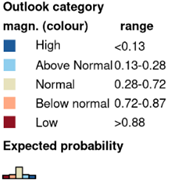

In [ ]:
#plot a histogram of the storage forecast ensemble for the given month
percs = [0.13, 0.28, 0.72, 0.87,1]
monthly_percentiles = training_data.storage.groupby(training_data.index.month).quantile(percs).reset_index().pivot(index='level_1', columns='date')
monthly_percentiles = monthly_percentiles.storage[month]
thresholds = np.concatenate([[0], monthly_percentiles])
counts, bins = np.histogram(forecasts, bins=thresholds)

labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
colors=['#ed6452','#ffa883','#e7e2bc','#8eceee','#4ba7de']
plt.bar(labels, counts, color=colors[:len(counts)], edgecolor="black",linewidth=2.5, width=1, align='center')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Remove ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("");


Given the narrow range of the storage forecast ensembles that we saw in our previous plot, it is not a surprise that the histogram shows only one category!

For comparison, here is a plot produced earlier for a reservoir in Wales which is much more dependent on climate inputs: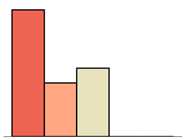

This plot shows much more variation - with many storage forecast ensemble members falling into the Low category, but many also anticipating Below Normal or Normal conditions.

🤔**Questions**
- Why do some climate forecasts produce an ensemble?
- How can ensemble forecasts help with decision making?